In [7]:
# Importing the necessary packages
import numpy as np                                  # "Scientific computing"

import pandas as pd                                 # Data Frame
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt                     # Basic visualisation

import seaborn as sns                               # Advanced data visualisation

from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/jdecorte/machinelearning/main/datasets/wdbc.csv')
# !! it is really important to give each of the columns an (appropriate) name, 
# otherwise you will get an error: all-features-must-be-in-0-9-or-10-0
# https://stackoverflow.com/questions/65789613/all-features-must-be-in-0-9-or-10-0
df.columns = ['id','diagnosis','radius','texture','perimeter','area','smoothness','compactness','concavity','concave points','symmetry','fractal dimension','radius_std','texture_std','perimeter_std','area_std','smoothness_std','compactness_std','concavity_std','concave points_std','symmetry_std','fractal dimension_std','radius_lg','texture_lg','perimeter_lg','area_lg','smoothness_lg','compactness_lg','concavity_lg','concave points_lg','symmetry_lg','fractal dimension_lg']
df.head()

,id,diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,...,radius_lg,texture_lg,perimeter_lg,area_lg,smoothness_lg,compactness_lg,concavity_lg,concave points_lg,symmetry_lg,fractal dimension_lg
0,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


## Model opbouwen

In [9]:
X = df.drop(['id', 'diagnosis'], axis = 1)
y = df['diagnosis']

In [10]:
numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns

col_transform = ColumnTransformer(transformers=[
    ('standard_scaler', StandardScaler(), numerical_ix)
    ])


In [11]:
from sklearn.model_selection import train_test_split    
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

In [12]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(426, 30) (142, 30) (426,) (142,)


## Grid-Search met een SVM Classifier

1. We willen de nauwkeurigheid voor elk van de vier classifiers weten. We willen vier classifiers testen: Logistische regressie, een RandomForestClassifier, een SVMClassifier en een Voting Classifier die de vorige drie classifiers gaat meegeven. Voor de voting classifier wordt er gewerkt met een 'harde' vote. We slaan elke classifier op in een array.
* Hard voting is wanneer we de voorspelling met het hoogst aantal stemmen gaan nemen. Soft voting is waarbij we de kansen gaan combineren per model en waarvan we de meest waarschijnlijke kans gaan nemen.

2. We willen iedere classifier testen op nauwkeurigheid. Hiervoor moeten we een for-lus gebruiken waarbij we iedere tuple van de array gaan afgaan.
2. We bouwen de Pipeline op met daarin de columntransformer en de classifier die we willen testen.
2. We trainen de pipeline en voorspellen labels op basis van de X_testset.
2. We bouwen een confusion matrix op. We zitten hier met binaire classifiers, dus we moeten .ravel() toevoegen aan de confusion matrix.
2. We printen de accuracy-score en de waarden uit de confusion matrix uit.

In [13]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)
vot_clf = VotingClassifier(estimators=[
    ('log_clf', log_clf),
    ('rnd_clf', rnd_clf),
    ('svm_clf', svm_clf)], voting='hard')

all_clf = [('log_clf', log_clf), ('rnd_clf', rnd_clf), ('svm_clf', svm_clf), ('vot_clf', vot_clf)]

In [15]:
for clf_tuple in all_clf:
  pipeline = Pipeline([
    ('prep',col_transform), 
    (clf_tuple[0], clf_tuple[1])
    ])

  pipeline.fit(X_train, y_train)

  y_pred = pipeline.predict(X_test)
  
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

  print(f"{clf_tuple[0]} accuracy_score = {accuracy_score(y_test, y_pred):.2%}  TN = {tn}   FP = {fp}   FN = {fn}   TP = {tp}")

log_clf accuracy_score = 96.48%  TN = 85   FP = 2   FN = 3   TP = 52
rnd_clf accuracy_score = 96.48%  TN = 85   FP = 2   FN = 3   TP = 52
svm_clf accuracy_score = 96.48%  TN = 86   FP = 1   FN = 4   TP = 51
vot_clf accuracy_score = 96.48%  TN = 85   FP = 2   FN = 3   TP = 52


## Grid-Search met een niet-lineaire classifier:

We passen de code van daarnet aan. We hebben enkel de SVMClassifier van daarnet niet meer nodig. Deze gaan we vervangen door een niet-lineaire SVM classifier.

De stappen herhalen zich hier.

In [17]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(C=1, coef0=1, degree=2, kernel='poly', random_state=42)

vot_clf = VotingClassifier(estimators=[
  ('log_clf', log_clf),
  ('rnd_clf', rnd_clf),
  ('svm_clf', svm_clf)], voting='hard')

all_clf = [('log_clf', log_clf), ('rnd_clf', rnd_clf), ('svm_clf', svm_clf), ('vot_clf', vot_clf)]

for clf_tuple in all_clf:
  pipeline = Pipeline([
    ('prep',col_transform), 
    (clf_tuple[0], clf_tuple[1])
])

  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  print(f"{clf_tuple[0]} accuracy_score = {accuracy_score(y_test, y_pred)}  TN = {tn}   FP = {fp}   FN = {fn}   TP = {tp}")

log_clf accuracy_score = 0.9647887323943662  TN = 85   FP = 2   FN = 3   TP = 52
rnd_clf accuracy_score = 0.9647887323943662  TN = 85   FP = 2   FN = 3   TP = 52
svm_clf accuracy_score = 0.9788732394366197  TN = 87   FP = 0   FN = 3   TP = 52
vot_clf accuracy_score = 0.971830985915493  TN = 86   FP = 1   FN = 3   TP = 52


## Grid-Search voor een Random Forest Classifier

Voor de RFC hebben we eerst een grid van parameters nodig. De estimators, maximaal aantal bladen en maximale diepte werden niet gegeven. 

1. We stellen een dictionary op van parameters die we willen gebruiken voor de GridSearch.
2. We maken een GridSearch-object aan bedoeld voor een RandomForestClassifier.
3. We bouwen een pipeline op met (net zoals bij de vorige twee GridSearches) eerst een columntransformer, gevolgd door de GridSearch.
4. We trainen de pipeline met de trainingsdata (X en y).
5. Als laatste vragen we de beste estimator en score op van de GridSearch. De best estimator kan later ingezet worden als model.

In [20]:
param_grid = { 
    'n_estimators': [100, 200, 400, 600],
    'max_leaf_nodes': [2, 4, 6, 10, 14, 16, 18],
    'max_depth' : [2, 4, 6, 8, 10]
}

grid_svc = GridSearchCV(RandomForestClassifier(random_state = 42), param_grid, scoring='accuracy', cv=3)

pipeline = Pipeline([
    ('prep',col_transform),
    ('grid_svc', grid_svc)
])

pipeline.fit(X_train, y_train)

print(f"best estimator = {grid_svc.best_estimator_}")
print(f"best score = {grid_svc.best_score_}")

best estimator = RandomForestClassifier(max_depth=6, max_leaf_nodes=10, n_estimators=200,
                       random_state=42)
best score = 0.9577464788732394


### Extra:
Het getrainde GridSearch-object geeft ons de mogelijkheid om de importance per feature op te vragen. Hieronder bouwen we een dataframe op met daarin per kolomnaam de feature importance.
1. We hebben twee variabelen: 'column_name' waar we de features van de trainingsset gaan meegeven. 'importance' waar we de feature importance gaan opvragen per feature.


In [21]:
importances = pd.DataFrame({'column_name': X.columns, 'importance': grid_svc.best_estimator_.feature_importances_})
importances

,column_name,importance
0,radius,0.060664
1,texture,0.013522
2,perimeter,0.069634
3,area,0.059164
4,smoothness,0.003836
5,compactness,0.011219
6,concavity,0.041026
7,concave points,0.085093
8,symmetry,0.001944
9,fractal dimension,0.002150


## Grid-Search met een soft-voting SVM classifier.

In [22]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(C=1, coef0=1, degree=2, kernel='poly', random_state=42, probability = True)
vot_clf = VotingClassifier(estimators=[
  ('log_clf', log_clf),
  ('rnd_clf', rnd_clf),
  ('svm_clf', svm_clf)], voting='soft')

all_clf = [('log_clf', log_clf), ('rnd_clf', rnd_clf), ('svm_clf', svm_clf), ('vot_clf', vot_clf)]

for clf_tuple in all_clf:
  pipeline = Pipeline([
    ('prep',col_transform),
    (clf_tuple[0], clf_tuple[1])
])

  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  print(f"{clf_tuple[0]} accuracy_score = {accuracy_score(y_test, y_pred)}  TN = {tn}   FP = {fp}   FN = {fn}   TP = {tp}")

log_clf accuracy_score = 0.9647887323943662  TN = 85   FP = 2   FN = 3   TP = 52
rnd_clf accuracy_score = 0.9647887323943662  TN = 85   FP = 2   FN = 3   TP = 52
svm_clf accuracy_score = 0.9788732394366197  TN = 87   FP = 0   FN = 3   TP = 52
vot_clf accuracy_score = 0.971830985915493  TN = 86   FP = 1   FN = 3   TP = 52


## Out-of-Bag Classifier

We gaan een BaggingClassifier opzetten om zo een logistisch model te verbeteren. De oob-score gaat berekend worden op data die niet perse gebruikt werd in de analyse van het model. Dit is verschillend met de validatiescore waarbij ieder element sowieso wordt gebruikt voor het trainen en/of testen, afhankelijk van moment. De kans is reëel dat een instantie niet wordt gebruikt voor het trainen, testen of zelfs beide.

1. We gaan een Pipeline maken met daarin eerst de voorbereiding (ColumnTransformer) en daarna de BaggingClassifier. Bij de BaggingClass. geven we het logistische regressiemodel mee. 

2. We trainen de pipeline en o.b.v. dit resultaat kunnen wij de nauwkeurigheid opvragen van het model.

De OoB-score is 0.9859154929577465
De accuracy van het model is = 97.18%  TN = 86   FP = 1   FN = 3   TP = 52
index = 72	correct = M   predicted = 0   scores = [0.88061361 0.11938639]
index = 412	correct = B   predicted = 1   scores = [0.46889804 0.53110196]
index = 296	correct = M   predicted = 0   scores = [0.99459606 0.00540394]
index = 39	correct = M   predicted = 0   scores = [0.87744274 0.12255726]


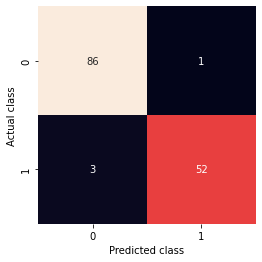

In [40]:
log_reg = LogisticRegression()

bag_clf = BaggingClassifier(log_reg, n_estimators=200, max_samples=150, bootstrap=True, n_jobs=-1, oob_score=True)

pipeline = Pipeline([
    ('prep',col_transform),
    ('bag_clf', bag_clf)
])

pipeline.fit(X_train, y_train)
print(f"De OoB-score is {pipeline[1].oob_score_}")

y_pred = pipeline.predict(X_test)
y_scores = pipeline.predict_proba(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"De accuracy van het model is = {accuracy_score(y_test, y_pred):.2%}  TN = {tn}   FP = {fp}   FN = {fn}   TP = {tp}")

conf_mx = confusion_matrix(y_test, y_pred)
labels = ['0','1']
cf = sns.heatmap(conf_mx,square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
cf.set_xlabel('Predicted class')
cf.set_ylabel('Actual class')

for ((index, correct), scores) in zip(y_test.items(), y_scores):
  predicted = np.argmax(scores)
  correct_0_1 = 0 if correct == 'B' else 1
  if correct_0_1 != predicted:
    print(f"index = {index}\tcorrect = {correct}   predicted = {predicted}   scores = {scores}")

## Extra:

We willen een overzicht krijgen van de fouten die iedere classifier kan maken.

1. We hebben dezelfde classifiers van daarnet nodig.

In [ ]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(C=1, coef0=1, degree=2, kernel='poly', random_state=42, probability = True)
vot_clf = VotingClassifier(estimators=[
  ('log_clf', log_clf),
  ('rnd_clf', rnd_clf),
  ('svm_clf', svm_clf)], voting='soft')

all_clf = [('log_clf', log_clf), ('rnd_clf', rnd_clf), ('svm_clf', svm_clf), ('vot_clf', vot_clf)]

2. Met een for-lus gaan we iedere classifier gaan doorlopen. We gaan een Pipeline opbouwen met daarin de columntransformer, gevolgd door de classifier waarvan we de scores willen analyseren.

3. Per classifier gaan we alle scores overlopen. 

In [27]:
for clf_tuple in all_clf:
  pipeline = Pipeline([
    ('prep',col_transform),
    (clf_tuple[0], clf_tuple[1])
])

  pipeline.fit(X_train, y_train)
  y_scores = pipeline.predict_proba(X_test)
  print(f"{clf_tuple[0]}")

  for ((index, correct), scores) in zip(y_test.items(), y_scores):
    predicted = np.argmax(scores)
    correct_0_1 = 0 if correct == 'B' else 1
    if correct_0_1 != predicted:
      print(f"index = {index}\tcorrect = {correct}   predicted = {predicted}   scores = {scores}")

log_clf
index = 72	correct = M   predicted = 0   scores = [0.94310467 0.05689533]
index = 412	correct = B   predicted = 1   scores = [0.46301094 0.53698906]
index = 296	correct = M   predicted = 0   scores = [0.99852898 0.00147102]
index = 39	correct = M   predicted = 0   scores = [0.90895473 0.09104527]
index = 362	correct = B   predicted = 1   scores = [0.49671608 0.50328392]
rnd_clf
index = 72	correct = M   predicted = 0   scores = [0.74 0.26]
index = 296	correct = M   predicted = 0   scores = [0.96 0.04]
index = 39	correct = M   predicted = 0   scores = [0.92 0.08]
index = 132	correct = B   predicted = 1   scores = [0.44 0.56]
index = 362	correct = B   predicted = 1   scores = [0.24 0.76]
svm_clf
index = 72	correct = M   predicted = 0   scores = [0.93126412 0.06873588]
index = 412	correct = B   predicted = 1   scores = [0.49268302 0.50731698]
index = 296	correct = M   predicted = 0   scores = [0.99626815 0.00373185]
index = 39	correct = M   predicted = 0   scores = [0.84483184 0.15

## Extra: ExtraTreesClass, AdaBoostClass en GradientBoostingClass

In [44]:
ext_clf = ExtraTreesClassifier(n_estimators=150, random_state=42)
ada_clf = AdaBoostClassifier(n_estimators=200, algorithm="SAMME.R", learning_rate=0.5, random_state = 42)
gbc_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0, max_depth=1, random_state=42)

all_clf = [
    ('ext_clf', ext_clf),
    ('ada_clf', ada_clf),
    ('gbc_clf', gbc_clf)
]

for clf_tuple in all_clf:
  
  pipeline = Pipeline([
    ('prep',col_transform),
    (clf_tuple[0], clf_tuple[1])
])
  
  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  print(f"{clf_tuple[0]} accuracy_score = {accuracy_score(y_test, y_pred)}  TN = {tn}   FP = {fp}   FN = {fn}   TP = {tp}")

ext_clf accuracy_score = 0.9647887323943662  TN = 86   FP = 1   FN = 4   TP = 51
ada_clf accuracy_score = 0.9647887323943662  TN = 87   FP = 0   FN = 5   TP = 50
gbc_clf accuracy_score = 0.9507042253521126  TN = 85   FP = 2   FN = 5   TP = 50
